# Problem Set 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Q1. Tauchen Method

Tauchen method is the simplest method to discretize an AR(1) process. An AR(1) process has the form

$$
x_{t} = \rho x_{t-1} + \epsilon_{t}
$$

where $\epsilon$ follows Normal distribution with standard deviation $\sigma$.

For discrete dynamic programming, it is usually useful to discretize the continuous AR(1) process. We need two ingredients: 1) the points (the states) on the finite state space; and 2) the transition probabilities between each pair of the states. Check the related pdf file.

For the rest of this question, we assume that $\rho = 0.95$ and $\sigma = 0.01$. We choose $m=4$ and $N=15$ for the process (see both of these definitions in the pdf file).

### Q1.1 Coding Tauchen method up
Define a function for Tauchen method that returns the finite state space and the transition matrix. (If you checked some references for this one please mention them)

In [27]:
# Parameters

rho = 0.96
sigma = 0.01
m = 4
N = 15

In [28]:
def Tauchen(rho, sigma, m, N):
    y_N = m * np.sqrt(sigma ** 2 / (1 - rho ** 2))
    y_grid = np.linspace(-y_N, y_N, N)
    d = 2 * y_N / (N - 1)
    F = stats.norm().cdf
    
    Pi = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if (j == 0):
                lb = 0.0
            else:
                lb = F((y_grid[j] - (d / 2) - rho * y_grid[i]) / sigma)
                
            if (j == N - 1):
                rb = 1.0
            else:
                rb = F((y_grid[j] + (d / 2) - rho * y_grid[i]) / sigma)
    
            Pi[i, j] = rb - lb

    return y_grid, Pi
            

In [29]:
y_grid, Pi = Tauchen(rho, sigma, m, N)

### Q1.2 Simulation and check the statistics
Now you have a discretized Markov Chain for this continuous AR(1) process. Randomly simulate this process for 1000 periods by setting the state of the first period as 8 (since we have 15 states and they are symmetric, the starting period would be 0). For the sample chain you got, compute the 1) autocorrelation of the realizations; 2) the unconditional variance of the process. What do you find?

In [32]:
# Iterate T times
T = 10000

ini_state = 8
res = np.zeros(T, dtype = int)
res[0] = ini_state
prob_draw = np.random.rand(T) # Draw all the probabilities in a row
for i in range(T - 1):
    cum_prob = np.cumsum(Pi[res[i], :])
    res[i + 1] = np.searchsorted(cum_prob, prob_draw[i])

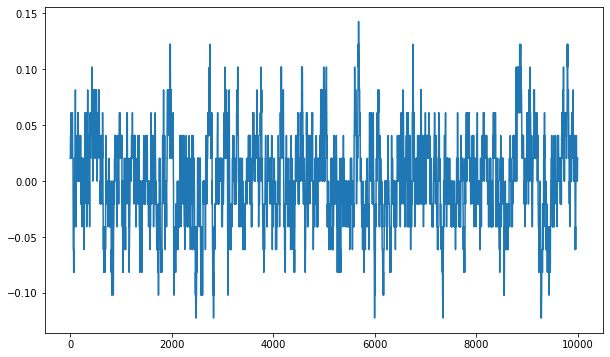

In [33]:
plt.figure(figsize = (10, 6))
plt.plot(y_grid[res])
plt.show()

In [34]:
# Compute the statistics
np.corrcoef(y_grid[res][:T-1], y_grid[res][1:])[0, 1] # autocorrelation

0.9561318610737418

In [35]:
np.var(y_grid[res]) # unconditional variance

0.0015513869179508537

## Q2. A Modified RBC model

We think about a model with the so-called "investment cost shock" instead of the usual TFP shock that we have. This question solves a drastically simplified version of Justiniano, Primiceri, and Tambalotti (2011).

Consider a representative agent that lives forever. Time is discrete. The agent wishes to maximize the expectation of discounted sum of utility,

$$
\max_{\left\{ c_{t}\right\} }\mathbb{E}\left[\sum_{t=0}^{\infty}\beta^{t}u\left(c_{t}\right)\right]
$$
 
This agent owns capital $k_t$ at the beginning of time period $t$, and produce some final output following a production function $y=f\left(k\right)$. She can choose to consume or to invest the final output, therefore, facing a budget constraint

$$
\begin{align*}
c_{t}+i_{t} & \leqslant y_{t}\\
y_{t} & =f\left(k_{t}\right)
\end{align*}
$$

There's an investment cost shock, denoted as $z$. $z$ is a discrete, exogenous Markov process. And the capital accumulates following

$$
k_{t+1}=\left(1-\delta\right)k_{t}+\exp\left(z_{t}\right)i_{t}
$$

The difference between this model and the classical RBC model that we covered in class is that the shock is no longer scaling the production function, but rather on the investment that agents choose.

### Q2.1 The Bellman equation

Write down the Bellman equation of this problem. As you Markovize this problem, you can denote the variables at time $t$ as $c,i,k,y,z$, and the variables at time $t+1$ as $c',i', k', y', z'$.

$$
\begin{align*}
V\left(z,k\right) & =\max_{c}\left\{ u\left(c\right)+\beta\mathbb{E}V\left(z',k'\right)\right\} \\
\text{s.t.}c+\left(k'-\left(1-\delta\right)k\right)/\exp\left(z\right) & \leqslant f\left(k\right)
\end{align*}
$$

### Q2.2 Solve the problem

We assume some functional forms and parameter values. $u\left(c\right)=\log\left(c\right)$, $f\left(k\right)=k^{\alpha}$. For the parameters,

| Parameter | Value |
|-----------|-------|
| $\alpha$  | 0.33  |
| $\beta$   | 0.96  |
| $\delta$  | 0.1   |

And $z$ follows a 3-state Markov chain,

$$
\begin{align*}
z & =\left[-0.02,0,0.02\right]\\
P & =\left[\begin{array}{ccc}
0.8 & 0.15 & 0.05\\
0.1 & 0.8 & 0.1\\
0.05 & 0.15 & 0.8
\end{array}\right]
\end{align*}
$$

Solve the value function (hint: the state variables are the same as what we did in the class -- both $z$ and $k$. You can probably use the same grid of capital that we did in class). Describe the economic intuition behind it.

In [39]:
# Parameterization
alpha = 1.0 / 3
beta = 0.96
gamma = 1.0
delta = 0.1

# A very simple z process
n_z = 3
z_grid = np.array([-0.02, 0, 0.02])
P = np.array([[0.8, 0.15, 0.05], [0.1, 0.8, 0.1], [0.05, 0.15, 0.8]])

In [41]:
def u_vec(c, gamma):
    if (gamma == 1.0):
        res = np.log(c)
    else:
        res = (c ** (1 - gamma)) / (1 - gamma)
    
    res[np.isnan(res)] = -1e10
    
    return res

In [42]:
# Production function
def f(k, alpha):
    return k ** alpha

In [49]:
# Make a grid
n_k = 1000
k_min = 2.0
k_max = 5.0
k_grid = np.linspace(k_min, k_max, n_k)

In [50]:
# Vectorize some operations
T = 100
V = np.zeros((T, n_z, n_k))
policy = np.zeros((n_z, n_k))
consumption = np.zeros((n_z, n_k))
investment = np.zeros((n_z, n_k))

for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            c_grid = f(k_grid[k], alpha) + ((1 - delta) * k_grid[k] - k_grid) / np.exp(z_grid[j])
            tmp = u_vec(c_grid, gamma) + beta * np.dot(P[j, :], V[i, :, :])
            V[i + 1, j, k] = np.max(tmp)
            policy[j, k] = k_grid[np.argmax(tmp)]
            consumption[j, k] = f(k_grid[k], alpha) - (policy[j,k] - (1 - delta) * k_grid[k]) / np.exp(z_grid[j])
            investment[j, k] = (policy[j, k] - (1 - delta) * k_grid[k])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


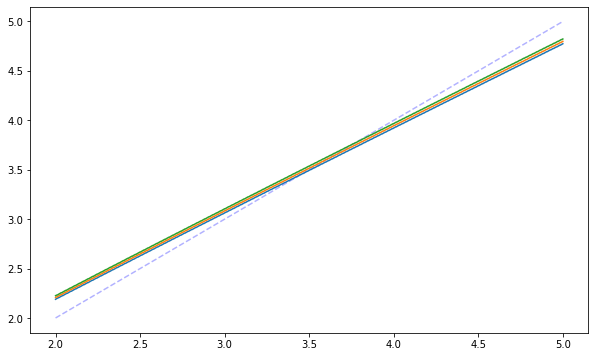

In [51]:
# Policy Function
plt.figure(figsize = (10, 6))
plt.plot(k_grid, k_grid, 'b--', alpha = 0.3)
plt.plot(k_grid, policy.T)
plt.show()